# Micromagnetic standard problem 4

**Author**: Marijan Beg, Marc-Antonio Bisotti

**Date**: 18 Mar 2016

In [1]:
import numpy as np
from math import sqrt

## Problem specification

The simulated sample is a thin film cuboid with dimensions:
- length $L = 500 \,\text{nm}$,
- width $d = 125 \,\text{nm}$, and
- thickness $t = 3 \,\text{nm}$.

In [2]:
from fidimag.common import CuboidMesh
mesh = CuboidMesh(nx=160, ny=40, nz=1, dx=3.125, dy=3.125, dz=3, unit_length=1e-9)

The material parameters (similar to permalloy) are:

- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8 \times 10^{5} \,\text{A/m}$.

Magnetisation dynamics is governed by the Landau-Lifshitz-Gilbert equation

$$\frac{d\mathbf{m}}{dt} = -\gamma_{0}(\mathbf{m} \times \mathbf{H}_\text{eff}) + \alpha\left(\mathbf{m} \times \frac{d\mathbf{m}}{dt}\right)$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ is the gyromagnetic ratio and $\alpha=0.02$ is the Gilbert damping.

In [3]:
A = 13e-12
Ms = 8.0e5
alpha = 0.02
gamma = 2.211e5

In the standard problem 4, the system is firstly relaxed at zero external magnetic field and then, stating from the obtained equlibrium configuration, the magnetisation dynamics is simulated for each of two different external magnetic fields:

1. $\mathbf{H}_{1} = (-24.6, 4.3, 0.0) \,\text{mT}$
2. $\mathbf{H}_{2} = (-35.5, -6.3, 0.0) \,\text{mT}$

The micromagnetic standard problem 4 specification can be also found in Ref. 1.

## Simulation

### Getting the Initial Magnetisation

The simulation object is created and parameters set.

In [4]:
from fidimag.micro import Sim, UniformExchange, Demag, Zeeman, TimeZeeman

sim = Sim(mesh)  # create simulation object
sim.Ms = Ms
sim.alpha = 0.5  # large value since the magnetisation dynamics is not important in the relexation stage
sim.gamma = gamma
sim.do_precession = False  # speeds up the simulation


# Starting magnetisation.
sim.set_m((1, 0.25, 0.1))

The energies are added to the simulation. We use `TimeZeeman` to model a decaying applied field.

In [5]:
sim.add(UniformExchange(A=A))
sim.add(Demag())

H0 = [Ms/sqrt(3) for _ in range(3)]
Ht = lambda t: 1 - t / 0.5e-9 if t < 0.5e-9 else 0
sim.add(TimeZeeman(H0, Ht))  # saturating field which is reduced over 0.5 nanoseconds

Finally, the system can be relaxed and the obtained equilibrium configuration saved, so that it can be used as an initial state for simulating magnetisation dynamics.

In [6]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
sim.set_m((1.0, 0.25, 0.1))
sim.set_tols(rtol=1e-10, atol=1e-10)
sim.relax(dt=1e-13, stopping_dmdt=0.01, max_steps=5000, save_m_steps=None, save_vtk_steps=None);
np.save("m0.npy", sim.spin)  # save equilibrium configuration

step=1, time=1e-13, max_dmdt=2617.79 ode_step=0
step=2, time=2e-13, max_dmdt=2587.93 ode_step=2.40116e-14
step=3, time=3e-13, max_dmdt=2558.71 ode_step=3.70756e-14
step=4, time=4e-13, max_dmdt=2530.12 ode_step=5.57677e-14
step=5, time=5e-13, max_dmdt=2508.12 ode_step=5.57677e-14
step=6, time=6e-13, max_dmdt=2486.88 ode_step=5.57677e-14
step=7, time=7e-13, max_dmdt=2465.86 ode_step=5.57677e-14
step=8, time=8e-13, max_dmdt=2445.06 ode_step=9.07016e-14
step=9, time=9e-13, max_dmdt=2424.46 ode_step=9.07016e-14
step=10, time=1e-12, max_dmdt=2404.07 ode_step=9.07016e-14
step=11, time=1.1e-12, max_dmdt=2383.88 ode_step=9.07016e-14
step=12, time=1.2e-12, max_dmdt=2363.89 ode_step=9.07016e-14
step=13, time=1.3e-12, max_dmdt=2344.09 ode_step=9.07016e-14
step=14, time=1.4e-12, max_dmdt=2324.49 ode_step=9.07016e-14
step=15, time=1.55947e-12, max_dmdt=2299.36 ode_step=1.59474e-13
step=16, time=1.71895e-12, max_dmdt=2268.88 ode_step=1.59474e-13
step=17, time=1.87842e-12, max_dmdt=2238.87 ode_step=1.

With the obtained relaxed magnetisation, the magnetisation evolution can be simulated for the two different external magnetic fields using the following function:

In [7]:
def field_simulation(H, name):
    print(name)
    sim = Sim(mesh, name)
    sim.alpha = alpha
    sim.gamma = gamma
    sim.Ms = Ms
    sim.add(UniformExchange(A=A))
    sim.add(Demag())
    sim.add(Zeeman(H))
    sim.set_m(np.load('m0.npy'))  # load the equilibrium magnetisation from the previous step
    
    timesteps = np.linspace(0, 1e-9, 101)
    for i, t in enumerate(timesteps):
        sim.run_until(t)
        if i % 10 == 0:
            print("\tsimulated {} s".format(t))

Using the created field_simulation function, we obtain the average magnetisation components time evolutions.

In [8]:
%%time
mu0 = 4 * np.pi * 1e-7  # magnetic constant (H/m)
mT = 1e-3 / mu0  # millitesla

field_simulation([-24.6 * mT,  4.3 * mT, 0], "field_1")
field_simulation([-35.5 * mT, -6.3 * mT, 0], "field_2")

field_1
	simulated 0.0 s
	simulated 1e-10 s
	simulated 2e-10 s
	simulated 3e-10 s
	simulated 4e-10 s
	simulated 5e-10 s
	simulated 6e-10 s
	simulated 7e-10 s
	simulated 8e-10 s
	simulated 9e-10 s
	simulated 1e-09 s
field_2
	simulated 0.0 s
	simulated 1e-10 s
	simulated 2e-10 s
	simulated 3e-10 s
	simulated 4e-10 s
	simulated 5e-10 s
	simulated 6e-10 s
	simulated 7e-10 s
	simulated 8e-10 s
	simulated 9e-10 s
	simulated 1e-09 s
CPU times: user 8min 51s, sys: 35.5 s, total: 9min 26s
Wall time: 4min 33s


We could have saved the magnetisation dynamics in python objects on the fly. Instead, we chose to make use of fidimag's automatic saving capabilities and will now read our simulation results back in. 

//anaconda/envs/p2/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


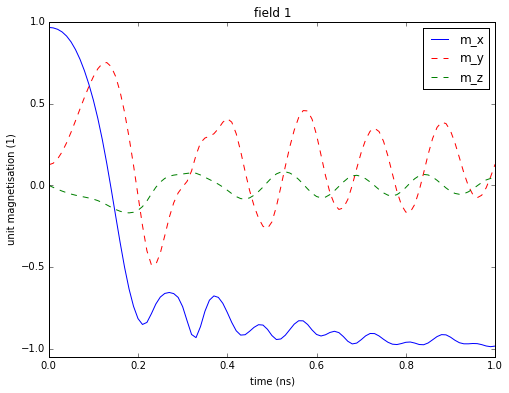

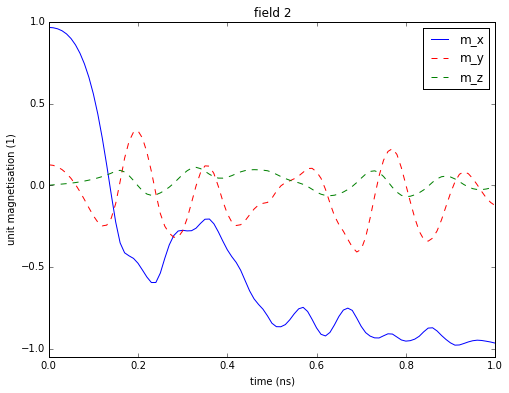

In [9]:
# PYTEST_VALIDATE_IGNORE_OUTPUT
import matplotlib.pyplot as plt
%matplotlib inline
from fidimag.common.fileio import DataReader

for f in (1, 2):
    dynamics = DataReader("field_{}.txt".format(f))
    # we could load the data with np.loadtxt, but using the DataReader gives 
    # us the possibility to use the column headers to access our data
    fig = plt.figure(figsize=(8, 6))
    axes = fig.add_subplot(111)
    axes.plot(dynamics["time"] * 1e9, dynamics["m_x"], "b-", label="m_x")
    axes.plot(dynamics["time"] * 1e9, dynamics["m_y"], "r--", label="m_y")
    axes.plot(dynamics["time"] * 1e9, dynamics["m_z"], "g--", label="m_z")
    axes.set_xlabel("time (ns)")                                             
    axes.set_xlim((0, 1))
    axes.set_ylabel("unit magnetisation (1)")                                
    axes.set_ylim((-1.05, 1))                                                
    axes.legend()
    axes.set_title("field {}".format(f))
    fig.show()

### References

[1] muMAG Micromagnetics Website. URL: http://www.ctcms.nist.gov/~rdm/mumag.org.html (Date of access: 26/02/2016)